# Creating the Gene Table
This notebook is copied from the [Pymodulon GitHub repository](https://github.com/SBRG/pymodulon/blob/master/docs/tutorials/creating_the_gene_table.ipynb)

In [1]:
from pymodulon.gene_util import *
import os

## Get information from GFF files

First, download the FASTA and GFF files for your organism and its plasmids from NCBI.

Enter the location of all your GFF files here:

In [2]:
gff_files = [os.path.join('..','data','external','genome.gff3')]

The following cell will convert all the GFF files into a single Pandas DataFrame for easy manipulation. Pseudogenes have multiple rows in a GFF file (one for each fragment), but only the first fragment will be kept.

In [3]:
keep_cols = ['accession','start','end','strand','gene_name','old_locus_tag','gene_product','ncbi_protein']

DF_annot = gff2pandas(gff_files,index='locus_tag')
DF_annot = DF_annot[keep_cols]

DF_annot.head()

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein
locus_tag,,,,,,,,
BSU_00010,AL009126.3,410,1750,+,dnaA,BSU00010,chromosomal replication initiator informationa...,CAB11777.1
BSU_00020,AL009126.3,1939,3075,+,dnaN,BSU00020,DNA polymerase III (beta subunit),CAB11778.1
BSU_00030,AL009126.3,3206,3421,+,rlbA,BSU00030,RNA binding protein involved in ribosome matur...,CAB11779.1
BSU_00040,AL009126.3,3437,4549,+,recF,BSU00040,RecA filament-DNA complex stabilisation%2C ssD...,CAB11780.1
BSU_00050,AL009126.3,4567,4812,+,remB,BSU00050,regulator of extracellular matrix formation,CAB11781.2


To ensure that the gene index used is identical to the expression matrix, load in your data.

In [5]:
log_tpm_file = os.path.join('..','data','processed_data','log_tpm.csv')
DF_log_tpm = pd.read_csv(log_tpm_file,index_col=0)
DF_log_tpm.head()

,ERX1819430,ERX1819431,ERX1819432,ERX1819433,ERX1819434,ERX1819435,ERX1819436,ERX1819437,ERX1819438,ERX1819439,...,SRX8138085,SRX8138086,SRX8138087,SRX8138088,SRX8170783,SRX8170784,SRX8170785,SRX8170786,SRX8170787,SRX8170788
Geneid,,,,,,,,,,,,,,,,,,,,,
BSU_00010,8.237575,8.130192,8.030387,8.206024,7.825586,8.622903,7.941125,8.646164,7.706521,8.583246,...,8.433765,8.529419,8.341657,8.263543,8.657549,8.478786,8.433765,7.260541,6.565363,7.067773
BSU_00020,8.136255,8.158228,7.944902,8.128301,7.768190,8.694702,7.880545,8.577549,7.412810,8.444759,...,8.091038,8.270998,8.050418,7.709570,8.360202,8.216292,8.091038,6.622539,6.213155,6.598885
BSU_00030,8.630541,8.667493,8.573422,8.624644,8.519212,8.784156,8.540263,8.756407,8.530356,8.599026,...,7.079890,7.036158,7.238490,7.012573,7.347623,7.185877,7.079890,6.661121,6.296518,6.104104
BSU_00040,8.937226,8.815450,8.826137,8.963782,9.188194,9.509172,9.208139,9.435232,9.224923,9.249384,...,8.867251,8.888843,8.769245,8.883008,8.866261,8.781089,8.867251,8.233104,7.977937,8.185906
BSU_00050,8.753770,8.519778,8.609053,8.771082,8.885464,9.207130,8.838806,9.069896,8.828876,8.898175,...,8.124430,8.332796,8.056326,8.269228,8.262207,8.061416,8.124430,7.677002,7.085650,7.396335


Check that the genes are the same in the expression dataset as in the annotation dataframe. Mismatched genes are listed below.

In [6]:
test = DF_annot.sort_index().index == DF_log_tpm.sort_index().index
DF_annot[~test]

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein
locus_tag,,,,,,,,


## (Optional) KEGG and COGs

### Generate nucleotide fasta files for CDS

Enter the location of all your fasta files here:

In [8]:
fasta_files = [os.path.join('..','data','external','genome.fasta')]

The following code generates CDS files using your FASTA and GFF3 files

In [9]:
from Bio import SeqIO

cds_list = []
for fasta in fasta_files:
    seq = SeqIO.read(fasta,'fasta')

    # Get gene information for genes in this fasta file
    df_genes = DF_annot[DF_annot.accession == seq.id]
    
    for i,row in df_genes.iterrows():
        cds = seq[row.start-1:row.end]
        if row.strand == '-':
            cds = seq[row.start-1:row.end].reverse_complement()
        cds.id = row.name
        cds.description = row.gene_name if pd.notnull(row.gene_name) else row.name
        cds_list.append(cds)

In [10]:
cds_list[:5]

[SeqRecord(seq=Seq('ATGGAAAATATATTAGACCTGTGGAACCAAGCCCTTGCTCAAATCGAAAAAAAG...TAG'), id='BSU_00010', name='AL009126.3', description='dnaA', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGAAATTCACGATTCAAAAAGATCGTCTTGTTGAAAGTGTCCAAGATGTATTA...TAA'), id='BSU_00020', name='AL009126.3', description='dnaN', dbxrefs=[]),
 SeqRecord(seq=Seq('ATGGCAAATCCGATTTCAATTGATACAGAGATGATTACACTCGGACAATTCTTA...TAA'), id='BSU_00030', name='AL009126.3', description='rlbA', dbxrefs=[]),
 SeqRecord(seq=Seq('TTGTATATCCAGAACTTAGAACTGACATCTTACCGCAACTACGACCATGCTGAA...TGA'), id='BSU_00040', name='AL009126.3', description='recF', dbxrefs=[]),
 SeqRecord(seq=Seq('TTGTATATTCATTTAGGTGATGACTTTGTGGTTTCAACACGAGATATTGTCGGC...TAG'), id='BSU_00050', name='AL009126.3', description='remB', dbxrefs=[])]

Save the CDS file

In [11]:
cds_file = os.path.join('..','data','external','CDS.fna')
SeqIO.write(cds_list, cds_file, 'fasta')

4325

### Run EggNOG Mapper
1. Go to http://eggnog-mapper.embl.de/.
1. Upload the CDS.fna file from your organism directory (within the sequence_files folder)
1. Make sure to limit the taxonomy to the correct level
1. After the job is submitted, you must follow the link in your email to run the job.
1. Once the job completes (after ~4 hrs), download the annotations file.
1. Save the annotation file

### Get KEGG IDs

Once you have the EggNOG annotations, load the annotation file

In [12]:
eggnog_file = os.path.join('..','data','external','eggNOG_annotations.txt')

In [13]:
DF_eggnog = pd.read_csv(eggnog_file,sep='\t',skiprows=4,header=None)
eggnog_cols = ['query_name','seed eggNOG ortholog','seed ortholog evalue','seed ortholog score',
               'Predicted taxonomic group','Predicted protein name','Gene Ontology terms',
               'EC number','KEGG_orth','KEGG_pathway','KEGG_module','KEGG_reaction',
               'KEGG_rclass','BRITE','KEGG_TC','CAZy','BiGG Reaction','tax_scope',
               'eggNOG OGs','bestOG_deprecated','COG','eggNOG free text description']

DF_eggnog.columns = eggnog_cols

# Strip last three rows as they are comments
DF_eggnog = DF_eggnog.iloc[:-3]

# Set locus tag as index
DF_eggnog = DF_eggnog.set_index('query_name')
DF_eggnog.index.name = 'locus_tag'

DF_eggnog.head()

,seed eggNOG ortholog,seed ortholog evalue,seed ortholog score,Predicted taxonomic group,Predicted protein name,Gene Ontology terms,EC number,KEGG_orth,KEGG_pathway,KEGG_module,...,KEGG_rclass,BRITE,KEGG_TC,CAZy,BiGG Reaction,tax_scope,eggNOG OGs,bestOG_deprecated,COG,eggNOG free text description
locus_tag,,,,,,,,,,,,,,,,,,,,,
BSU_00010,224308.BSU00010,1.300000e-251,875.2,Bacillus,dnaA,"GO:0003674,GO:0003676,GO:0003677,GO:0003688,GO...",NaN,ko:K02313,"ko02020,ko04112,map02020,map04112",NaN,...,NaN,"ko00000,ko00001,ko03032,ko03036",NaN,NaN,NaN,Bacillus,"1TPV7@1239,1ZBKI@1386,4H9MW@91061,COG0593@1,CO...",NA|NA|NA,L,it binds specifically double-stranded DNA at a...
BSU_00020,224308.BSU00020,1.000000e-204,719.2,Bacillus,dnaN,NaN,2.7.7.7,ko:K02338,"ko00230,ko00240,ko01100,ko03030,ko03430,ko0344...",M00260,...,RC02795,"ko00000,ko00001,ko00002,ko01000,ko03032,ko03400",NaN,NaN,NaN,Bacillus,"1TQ7J@1239,1ZAVV@1386,4H9TF@91061,COG0592@1,CO...",NA|NA|NA,L,Confers DNA tethering and processivity to DNA ...
BSU_00030,224308.BSU00030,4.000000e-33,146.7,Bacillus,yaaA,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Bacillus,"1VEJ2@1239,1ZIXZ@1386,4HNMC@91061,COG2501@1,CO...",NA|NA|NA,S,S4 domain
BSU_00040,224308.BSU00040,2.400000e-206,724.5,Bacillus,recF,"GO:0000731,GO:0005575,GO:0005622,GO:0005623,GO...",NaN,ko:K03629,"ko03440,map03440",NaN,...,NaN,"ko00000,ko00001,ko03400",NaN,NaN,NaN,Bacillus,"1TP9U@1239,1ZC8V@1386,4HA0W@91061,COG1195@1,CO...",NA|NA|NA,L,it is required for DNA replication and normal ...
BSU_00050,224308.BSU00050,4.000000e-37,160.2,Bacillus,yaaB,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Bacillus,"1VEZV@1239,1ZIZ5@1386,2E36Q@1,32Y6E@2,4HQTK@91061",NA|NA|NA,S,Domain of unknown function (DUF370)


Now we will pull the KEGG information from the eggNOG file, including orthology, pathway, module, and reactions for each gene.

In [14]:
DF_kegg = DF_eggnog[['KEGG_orth','KEGG_pathway','KEGG_module','KEGG_reaction']]

# Melt dataframe
DF_kegg = DF_kegg.reset_index().melt(id_vars='locus_tag') 

# Remove null values
DF_kegg = DF_kegg[DF_kegg.value.notnull()]

# Split comma-separated values into their own rows
list2struct = []
for name,row in DF_kegg.iterrows():
    for val in row.value.split(','):
        list2struct.append([row.locus_tag,row.variable,val])

DF_kegg = pd.DataFrame(list2struct,columns=['gene_id','database','kegg_id'])

# Remove ko entries, as only map entries are searchable in KEGG pathway
DF_kegg = DF_kegg[~DF_kegg.kegg_id.str.startswith('ko')]

DF_kegg.head()

,gene_id,database,kegg_id
2553,BSU_00010,KEGG_pathway,map02020
2554,BSU_00010,KEGG_pathway,map04112
2561,BSU_00020,KEGG_pathway,map00230
2562,BSU_00020,KEGG_pathway,map00240
2563,BSU_00020,KEGG_pathway,map01100


### Save KEGG information

In [15]:
DF_kegg.to_csv(os.path.join('..','data','external','kegg_mapping.csv'))

### Save COGs to annotation dataframe

In [16]:
DF_annot['COG'] = DF_eggnog.COG

# Make sure COG only has one entry per gene
DF_annot['COG'] = [item[0] if isinstance(item,str) else item for item in DF_annot['COG']]

## Uniprot ID mapping

The ``uniprot_id_mapping`` function is a python wrapper for the [Uniprot ID mapping tool](https://www.uniprot.org/uploadlists/). Use ``input_id=P_REFSEQ_AC`` if the FASTA/GFF files are from RefSeq, and ``input_id=EMBL`` if the files are from Genbank.

In [17]:
mapping_uniprot = uniprot_id_mapping(DF_annot.ncbi_protein.fillna(''),input_id='EMBL',output_id='ACC',
                             input_name='ncbi_protein',output_name='uniprot')
mapping_uniprot.head()

,ncbi_protein,uniprot
341,SOX90541.1,A0A2K4Z9F2
442,SOX90542.1,A0A2K4Z9F4
279,SOX90540.1,A0A2K4Z9F5
497,SOX90545.1,A0A2K4Z9F9
179,SOX90537.1,A0A2K4Z9G0


In [18]:
# Merge with current annotation
DF_annot = pd.merge(DF_annot.reset_index(),mapping_uniprot,how='left',on='ncbi_protein')
DF_annot.set_index('locus_tag',inplace=True)
DF_annot.head()

,accession,start,end,strand,gene_name,old_locus_tag,gene_product,ncbi_protein,COG,uniprot
locus_tag,,,,,,,,,,
BSU_00010,AL009126.3,410,1750,+,dnaA,BSU00010,chromosomal replication initiator informationa...,CAB11777.1,L,P05648
BSU_00020,AL009126.3,1939,3075,+,dnaN,BSU00020,DNA polymerase III (beta subunit),CAB11778.1,L,P05649
BSU_00030,AL009126.3,3206,3421,+,rlbA,BSU00030,RNA binding protein involved in ribosome matur...,CAB11779.1,S,P05650
BSU_00040,AL009126.3,3437,4549,+,recF,BSU00040,RecA filament-DNA complex stabilisation%2C ssD...,CAB11780.1,L,P05651
BSU_00050,AL009126.3,4567,4812,+,remB,BSU00050,regulator of extracellular matrix formation,CAB11781.2,S,P37525


## Add Biocyc Operon information

To obtain operon information from Biocyc, follow the steps below

1. Go to [Biocyc.org](https://biocyc.org/) (you may need to create an account and/or login)
2. Change the organism database to your organism/strain
3. Select **SmartTables** -> **Special SmartTables**
4. Select **"All genes of \<organism\>"**
5. Select the **"Gene Name"** column
6. Under **"ADD TRANSFORM COLUMN"** select **"Genes in same transcription unit"**
7. Select the **"Genes in same transcription unit"** column
8. Under **"ADD PROPERTY COLUMN"** select **"Accession-1"**
9. Under **OPERATIONS**, select **"Export"** -> **"to Spreadsheet File..."**
10. Select **"common names"** and click **"Export smarttable"**
11. Add file location below and run the code cell

In [20]:
biocyc_file = os.path.join('..','data','external','biocyc_annotations.txt')

DF_biocyc = pd.read_csv(biocyc_file,sep='\t')

# Remove genes with no accession
DF_biocyc = DF_biocyc[DF_biocyc['Accession-1'].notnull()]

# Set the accession (i.e. locus tag) as index
DF_biocyc = DF_biocyc.set_index('Accession-1').sort_values('Left-End-Position')

# Specific for B. subtilis: Fix locus tags
DF_biocyc.index = DF_biocyc.index.str.replace('BSU','BSU_')

# Only keep genes in the final annotation file
DF_biocyc = DF_biocyc.reindex(DF_annot.index)

# Reformat transcription units
DF_biocyc['operon_list'] = DF_biocyc['Accession-1.1'].apply(reformat_biocyc_tu)

# Fill None with locus tags
DF_biocyc['operon_list'].fillna(DF_biocyc.index.to_series(), inplace=True)

DF_biocyc.head()

,Gene Name,Left-End-Position,Right-End-Position,Product,Genes in same transcription unit,Accession-1.1,operon_list
locus_tag,,,,,,,
BSU_00010,dnaA,410.0,1750.0,chromosomal replication initiator informationa...,dnaN // dnaA,dnaN // dnaA,dnaA;dnaN
BSU_00020,dnaN,1939.0,3075.0,DNA polymerase III (beta subunit),dnaN // dnaA,dnaN // dnaA,dnaA;dnaN
BSU_00030,yaaA,3206.0,3421.0,RNA binding protein involved in ribosome matur...,gyrB // remB // recF // yaaA,gyrB // remB // recF // yaaA,gyrB;recF;remB;yaaA
BSU_00040,recF,3437.0,4549.0,"RecA filament-DNA complex stabilisation, ssDNA...",gyrB // remB // recF // yaaA,gyrB // remB // recF // yaaA,gyrB;recF;remB;yaaA
BSU_00050,remB,4567.0,4812.0,regulator of extracellular matrix formation,gyrB // remB // recF // yaaA,gyrB // remB // recF // yaaA,gyrB;recF;remB;yaaA


### Assign unique IDs to operons

The following code assigns unique names to each operon

In [21]:
# Get all operons
operons = DF_biocyc['operon_list'].unique()

# Map each operon to a unique string
operon_dict = {operon: "Op"+str(i) for i, operon in enumerate(operons)}

# Add names to dataframe
DF_biocyc['operon'] = [operon_dict[op] for op in DF_biocyc["operon_list"]]

DF_biocyc.head()

,Gene Name,Left-End-Position,Right-End-Position,Product,Genes in same transcription unit,Accession-1.1,operon_list,operon
locus_tag,,,,,,,,
BSU_00010,dnaA,410.0,1750.0,chromosomal replication initiator informationa...,dnaN // dnaA,dnaN // dnaA,dnaA;dnaN,Op0
BSU_00020,dnaN,1939.0,3075.0,DNA polymerase III (beta subunit),dnaN // dnaA,dnaN // dnaA,dnaA;dnaN,Op0
BSU_00030,yaaA,3206.0,3421.0,RNA binding protein involved in ribosome matur...,gyrB // remB // recF // yaaA,gyrB // remB // recF // yaaA,gyrB;recF;remB;yaaA,Op1
BSU_00040,recF,3437.0,4549.0,"RecA filament-DNA complex stabilisation, ssDNA...",gyrB // remB // recF // yaaA,gyrB // remB // recF // yaaA,gyrB;recF;remB;yaaA,Op1
BSU_00050,remB,4567.0,4812.0,regulator of extracellular matrix formation,gyrB // remB // recF // yaaA,gyrB // remB // recF // yaaA,gyrB;recF;remB;yaaA,Op1


Finally, merge the Biocyc information with the main annotation DataFrame

In [22]:
DF_annot['operon'] = DF_biocyc['operon']

## Clean up and save annotation

First, we will re-order the annotation columns

In [23]:
if 'old_locus_tag' in DF_annot.columns:
    order = ['gene_name','accession','old_locus_tag','start','end','strand','gene_product','COG','uniprot','operon']
else:
    order = ['gene_name','accession','start','end','strand','gene_product','COG','uniprot','operon']
    
DF_annot = DF_annot[order]

In [24]:
DF_annot.head()

,gene_name,accession,old_locus_tag,start,end,strand,gene_product,COG,uniprot,operon
locus_tag,,,,,,,,,,
BSU_00010,dnaA,AL009126.3,BSU00010,410,1750,+,chromosomal replication initiator informationa...,L,P05648,Op0
BSU_00020,dnaN,AL009126.3,BSU00020,1939,3075,+,DNA polymerase III (beta subunit),L,P05649,Op0
BSU_00030,rlbA,AL009126.3,BSU00030,3206,3421,+,RNA binding protein involved in ribosome matur...,S,P05650,Op1
BSU_00040,recF,AL009126.3,BSU00040,3437,4549,+,RecA filament-DNA complex stabilisation%2C ssD...,L,P05651,Op1
BSU_00050,remB,AL009126.3,BSU00050,4567,4812,+,regulator of extracellular matrix formation,S,P37525,Op1


## Final statistics

The following graphs show how much information is available for the organism.

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('ticks')

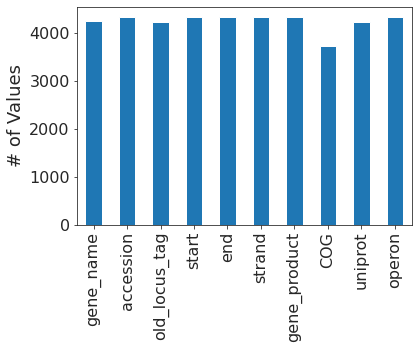

In [26]:
fig,ax = plt.subplots()
DF_annot.count().plot(kind='bar',ax=ax)
ax.set_ylabel('# of Values',fontsize=18)
ax.tick_params(labelsize=16)

## Fill missing values

Some organisms are missing gene names, so these will be filled with locus tag gene names.

In [27]:
# Fill in missing gene names with locus tag names
DF_annot['tmp_name'] = DF_annot.copy().index.tolist()
DF_annot.gene_name.fillna(DF_annot.tmp_name,inplace=True)
DF_annot.drop('tmp_name',axis=1,inplace=True)

 COG letters will also be converted to the full name.

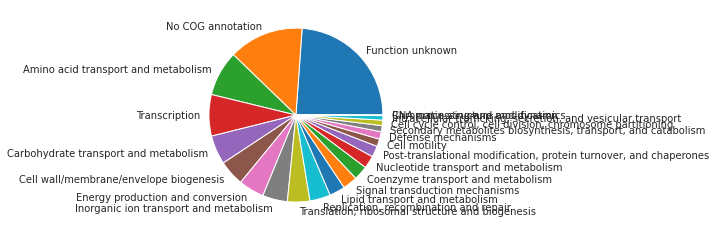

In [28]:
# Fill missing COGs with X
DF_annot['COG'].fillna('X',inplace=True)

# Change single letter COG annotation to full description
DF_annot['COG'] = DF_annot.COG.apply(cog2str)

counts = DF_annot.COG.value_counts()
plt.pie(counts.values,labels=counts.index);

Uncomment the following line to save the gene annotation dataset

In [29]:
DF_annot.to_csv(os.path.join('..','data','processed_data','gene_info.csv'))

## GO Annotations

To start, download the GO Annotations for your organism from AmiGO 2

1. Go to [AmiGO 2](http://amigo.geneontology.org/amigo/search/annotation)
1. Filter for your organism
1. Click ``CustomDL``
1. Drag ``GO class (direct)`` to the end of your Selected Fields
1. Enter the location of your GO annotation file below and run the following code block

In [31]:
go_file = os.path.join('..','data','external','GO_annotations.txt')

In [32]:
DF_GO = pd.read_csv(go_file,sep='\t',header=None,usecols=[2,17])
DF_GO.columns = ['gene_name','gene_ontology']
DF_GO.head()

,gene_name,gene_ontology
0,flhA,plasma membrane
1,flhA,bacterial-type flagellum assembly
2,glpP,"transcription antitermination factor activity,..."
3,rpsK,translation
4,rpsK,small ribosomal subunit rRNA binding


Convert the gene names to gene locus tags, and drop gene names that cannot be converted

In [33]:
name2num = {v:k for k,v in DF_annot.gene_name.to_dict().items()}

In [34]:
DF_GO['gene_id'] = [name2num[x] if x in name2num.keys() else None for x in DF_GO.gene_name]

In [35]:
DF_GO.head()

,gene_name,gene_ontology,gene_id
0,flhA,plasma membrane,BSU_16390
1,flhA,bacterial-type flagellum assembly,BSU_16390
2,glpP,"transcription antitermination factor activity,...",BSU_09270
3,rpsK,translation,BSU_01420
4,rpsK,small ribosomal subunit rRNA binding,BSU_01420


Now we remove null entries

In [36]:
DF_GO = DF_GO[DF_GO.gene_id.notnull()]

In [37]:
DF_GO.head()

,gene_name,gene_ontology,gene_id
0,flhA,plasma membrane,BSU_16390
1,flhA,bacterial-type flagellum assembly,BSU_16390
2,glpP,"transcription antitermination factor activity,...",BSU_09270
3,rpsK,translation,BSU_01420
4,rpsK,small ribosomal subunit rRNA binding,BSU_01420


Uncomment the line below to save the annotations

In [38]:
DF_GO[['gene_id','gene_name','gene_ontology']].to_csv(os.path.join('..','data','external','GO_annotations_curated.csv'))